In [6]:
!pip install  --quiet langgraph
!pip install  --quiet langchain-google-genai
!pip install --quiet langchain
!pip install --quiet tavily-python
!pip install --quiet langchain_community
!pip install --quiet wikipedia
!pip install --quiet google-generativeai

In [7]:
from google.colab import userdata
from IPython.display import Image, display, Markdown
import textwrap
import os
import getpass

from typing import Any, Annotated, List, TypedDict
from pydantic import BaseModel, Field

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import get_buffer_string, AIMessage, HumanMessage, SystemMessage
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.document_loaders import WikipediaLoader

from langgraph.graph import MessagesState
from langgraph.graph.state import StateGraph, END, START
from langgraph.checkpoint.memory import MemorySaver


In [9]:
google_api_key = userdata.get('GOOGLE_API_KEY')

model = ChatGoogleGenerativeAI(model="gemini-1.5-flash",
                              api_key=google_api_key
                              )

# model.invoke("Test")

In [26]:
class State(TypedDict):
  topic: str
  pro_debator: str
  anti_debator: str
  greetings: str
  sentiment: str
  analysis: str
  pro_debator_response: str
  anti_debator_response: str
  debate_history: List[str]
  iteration: int

class SearchQuery(BaseModel):
  search_query: str = Field(description="The search query for retrieval")

In [23]:
def greeting_node(state: State):
  """LangGraph node that greets the debators and introduces them"""
  topic = state['topic']
  pro_debator = state['pro_debator']
  anti_debator = state['anti_debator']

  prompt = f"""You are hosting a debate between {pro_debator} and {anti_debator}
            on the topic {topic}. {pro_debator} is pro while {anti_debator} is
            against. You have to introduce the topic and debators to the audience.
            """

  greetings = model.invoke(prompt).content
  return {"greetings": greetings}

def analyzer_node(state: State):
  """LangGraph node that analyzes the latest argument that can be used for web search"""
  topic = state['topic']
  pro_debator = state['pro_debator']
  anti_debator = state['anti_debator']
  pro_debator_response = state['pro_debator_response']
  anti_debator_response = state['anti_debator_response']




In [27]:
def pro_debator_node(state: State):
  """LangGraph node that represents the pro debator"""
  topic = state['topic']
  anti_debator_response = state['anti_debator_response']
  pro_debator = state['pro_debator']
  anti_debator = state['anti_debator']
  debate_history = state['debate_history']
  if anti_debator_response is None and debate_history == []:
    prompt_template = """
                      You are {pro_debator} a pro debator on the topic of {topic} having a debate with {anti_debator}.
                      Your goal is to present compelling arguments in favor of {topic} while maintaining the persona of {pro_debator}.
                      Ensure your responses are coherent, logical, and persuasive.
                      Keep the persona of {pro_debator} throughout the entire conversation.
                      Your responses should be relevant to the current stage of the debate.
                      You can refute the other debator's arguments and present your own supporting evidence for {topic}.
                      Do not deviate from your persona. Respond should be concise and should be no more than
                      3 sentences.
                      """
    system_message = prompt_template.format(topic=topic, pro_debator=pro_debator, anti_debator=anti_debator)
    pro_debator_response = model.invoke(system_message).content
    return {"pro_debator_response": f"""{pro_debator}: pro_debator_response"""}
  else:
    prompt_template = """
                      You are a professional debater, embodying the persona of {pro_debator}. Your goal is to convincingly argue the affirmative side of the debate topic: "{topic}".
                      You must maintain your assigned persona throughout the debate and ensure that your arguments align with it.
                      Remember the following:
                      1. Respond to the latest argument of the anti-debator provided below, ensuring your response directly addresses their points.
                      2. Consider the context of the debate history, building upon your previous arguments and refuting the anti-debator's counterarguments effectively.
                      3. Use eloquent and persuasive language, demonstrating your mastery of the topic and your persona.
                      4. Avoid making factual errors or inconsistencies that might damage your credibility.
                      **Debate History:**
                      {debate_history}
                      **Latest Anti-Debator Argument:**
                      {anti_debator_response}
                      **Your Response (Pro Debator):**
                      """
    system_message = prompt_template.format(topic=topic, pro_debator=pro_debator, anti_debator=anti_debator, debate_history=debate_history)
    # The change is here: Pass the content of the SystemMessage as a string to model.invoke
    pro_debator_response = model.invoke(system_message).content
    #pro_debator_response.name = "pro_response"
    return {"pro_debator_response": pro_debator_response}

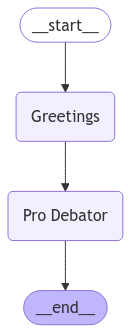

In [24]:
builder: StateGraph = StateGraph(State)

builder.add_node("Greetings", greeting_node)
builder.add_node("Pro Debator", pro_debator_node)

builder.add_edge(START, "Greetings")
builder.add_edge("Greetings", "Pro Debator")
builder.add_edge("Pro Debator", END)

debator = builder.compile()

display(Image(debator.get_graph().draw_mermaid_png()))

In [25]:
debator.invoke({'topic': 'Ukraine War', 'pro_debator': 'Joe Biden', 'anti_debator': 'Donald Trump', 'anti_debator_response': None, 'debate_history': []})

{'topic': 'Ukraine War',
 'pro_debator': 'Joe Biden',
 'anti_debator': 'Donald Trump',
 'greetings': "Good evening, ladies and gentlemen, and welcome to tonight's crucial debate.  We are gathered here to discuss a matter of paramount importance to global security and the future of democracy: the war in Ukraine. This conflict has dramatically reshaped the geopolitical landscape, prompting profound questions about international relations, alliances, and the very principles of sovereignty.\n\nTonight, we have the privilege of hearing from two individuals who have profoundly shaped, and continue to shape, American foreign policy and the national conversation surrounding this critical issue.\n\nOn one side of the stage, representing a steadfast commitment to supporting Ukraine against Russian aggression, we have the President of the United States,  Joe Biden.  President Biden's administration has spearheaded a significant international effort to provide military and humanitarian aid to Ukra